## **Name :** Eoghan O'Connor

###**Note**
 In this notebook I'm using the sheep dataset seems to be more complicated  but both Dog and Sheep datasets work.

# Etivity Assignment 2: Object co-localisation
In this assignment we will use the [Deep Descriptor Transforming (DDT) Technique](https://arxiv.org/pdf/1707.06397.pdf) to perform object co-localisation. The object localisation task involves finding the location of the primary object in an image (same object as image classification result). In the object co-localisation task the goal is to find the objects in images all of the same class. As detailed in the DDT paper, this can be achieved in a unsuperivsed manner from the feature map outputs of a pre-trained network. (In the image: Green bounding box is ground truth, Red boxes are obtained from DDT)
![link text](https://github.com/tonyscan6003/etivities/blob/main/etivity3_assignment_img.JPG?raw=true)

This technique (like Class activiation mapping) demonstrates that spatial information is contained with Deep Neural Networks trained for classification. This information can be used to generate region proposals or for direct object detection. The  unsupervised technique proposed in this paper is useful as it avoids the necessity of having bounding box information to adapt the pre-trained network for localisation.

In this Assignment you will perform object co-localisation using the stanford dogs dataset and the pre-trained VGG-16 network. This Jupyter notebook loads the stanford dogs dataset and also sets up the pre-trained Keras VGG-16 model so that the features of the convolutional layer are output. (Output layers of the model can be changed if required).  

In section 4. of the notebook you will implement the DDT algorithm and demonstrate prediction of bounding boxes. (Ground truth bounding boxes are available for comparison with your prediction).

You may find the following information useful:

*   [Sklearn PCA Functions](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [Tensorflow resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) (interpolation function)
*   OpenCV Connected Components (PyImageSearch example [link text](https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/)) Note that if you want to use OpenCv on the output tensors then it will be necessary to need to convert the tensor to a numpy array uisng `.numpy()` and also ensure that have the numpy array in uint8 format `.astype(np.uint8)`
* If you wish to display any of the images from the dataset, please note that they have been processed prior to input to the network. In order to unprocess the image for display, please use: `helper.unprocess_image(img)`

In order to obtain an exemplary grade you will be required to implement the DDT+ algorithm. This will involve use of additional feature map information to refine the position of the bounding box compared to the basic approach (as shown in the images below). You will implement the DDT+ algorithm on the [Pascale Visual Object Classes Challenge](https://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf) "Sheep" class. This is more challenging than the stanford dogs dataset, as objects appear at different scales. Note that the DDT+ approach also causes failures in bounding boxes for many images, you can comment on this in your notebook. 

Image: DDT+ Performance (Cyan: DDT+ bouding boxes, Red DDT: bounding boxes, Green: Ground Truth) 

![link text](https://github.com/tonyscan6003/etivities/blob/main/etivity3b_assignment.JPG?raw=true)

* Note: Completed list of VoC Classes 0-airplane, 1-bicycle, 2-bird, 3-boat, 4-bottle, 5-bus, 6-car, 7-cat, 8-chair, 9-cow, 10-dining table, 11-dog, 12-horse, 13-motorbike, 14-person, 15-potted plant, 16-sheep, 17-sofa, 18-train, 19-TV/monitor.










# 1. HouseKeeping
 Clone Repository & Import Packages 

In [ ]:
# Clone repository to gain access to helper.py
!git clone https://github.com/tonyscan6003/etivities.git

fatal: destination path 'etivities' already exists and is not an empty directory.


In [ ]:
import tensorflow as tf
import etivities.helper as helper
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA

In [ ]:
# Global Variables
HW_trg = helper.myList[0]      # Target Input Image size
batch_size = helper.myList[1]  # Batch Size
# data_set = ["stanford_dogs"]   # Dataset (and add class integer to list for VoC))
data_set = ["voc",16]    # VoC Dataset with Sheep Class

## 2A. Import Dataset

In [ ]:

if data_set[0] == "voc":   
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_val_dataset,info = tfds.load(data_set[0],split='validation',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
elif data_set[0] == "stanford_dogs":
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='~/tensorflow_datasets/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868.

## 2B. Create Train and Test dataset splits 

Note that the images from the stanford dog and many other datasets are not uniform in size. The `gen_datasets` function calls other routines from helper.py that scale the images from the dataset so the longest side fits into the 224 x 224 input window size of VGG16. The aspect ratio of the image is preserved, so the shorter side of the image is padded with zeros. The shorter side is randomly translated providing some data augmentation. (Augmentation is not important for this task). The routines also scale ground truth bounding boxes to match the scale and translation of the image.

In [ ]:
train_dataset, test_dataset =helper.gen_datasets(data_set,src_train_dataset,src_test_dataset)

Display Some Training Images with Ground truth Bounding Box

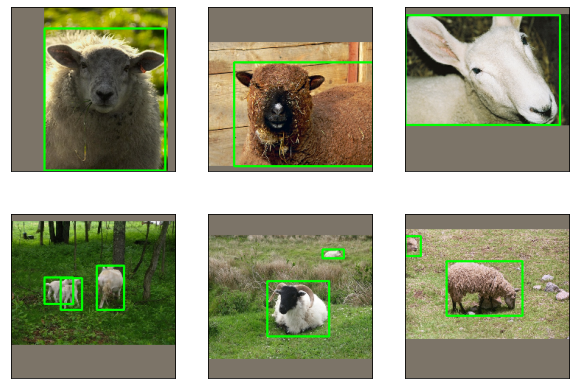

In [ ]:

helper.display_dataset_img(train_dataset)


## 3A. Import and Setup VGG model
For this assignment we will use the convolutional layers of the VGG-16 module. The sturucture & layer names of the VGG-16 can be viewed on [Netscope](https://ethereon.github.io/netscope/#/preset/vgg-16). The layer_names variable allows selection of the output layer(s) of the model.


In [ ]:
print(HW_trg, HW_trg )

224 224


In [ ]:
# Select Output Layers
layer_names = ['block4_conv3','block5_conv3']

# Load base model
def base_vgg_model():
   IMG_SHAPE = (HW_trg, HW_trg, 3)
   base_vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
   
   op_list=[base_vgg_model.get_layer(layer).output for layer in layer_names]
   base_model= tf.keras.Model(inputs=base_vgg_model.input, outputs=op_list)

   return base_model


In [ ]:
base_model = base_vgg_model()
base_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## 3B. Extract output features maps from Model.

The function `gen_batch_features` in the code cell below applies `n_img` images from the test or training set to the model. The function returns batch tensors of the image, ground truth boxes and features. The 0 dimension of the tensor corresponds to each image/feature pair.

In [ ]:
def gen_batch_features(train_dataset,n_img):

  cntr = 0
  for img, boxes, obj_cen, labels in train_dataset.take(n_img):
      img = img.to_tensor(shape=[batch_size, HW_trg, HW_trg, 3])
      A = base_model(img)[0]
      B = base_model(img)[1]

       # Append output features 
      if cntr >0:
        op_features1 = tf.concat([op_features1, A], axis=0)
        op_features2 = tf.concat([op_features2, B], axis=0)
        img_batch = tf.concat([img_batch, img], axis=0)
        boxes_batch = tf.concat([boxes_batch, boxes], axis=0)
      else:   
        op_features1 = A
        op_features2 = B
        img_batch = img
        boxes_batch = boxes
      cntr +=1  
     
  return img_batch, boxes_batch, op_features1, op_features2 

In [ ]:
n_img=100 # Default value.
img_batch, batch_boxes, op_features1, op_features2 = gen_batch_features(train_dataset,n_img)
img_batch_test, batch_boxes_test, op_features_test1, op_features_test2 = gen_batch_features(test_dataset,n_img)
print(np.shape(op_features1))
print(np.shape(op_features2))

print("test")
print(np.shape(op_features_test1))
print(np.shape(op_features_test2))

print(np.shape(batch_boxes_test))
print(np.shape(img_batch_test))

(45, 28, 28, 512)
(45, 14, 14, 512)
test
(93, 28, 28, 512)
(93, 14, 14, 512)
(93, None, 4)
(93, 224, 224, 3)


# **4. DDT Algorithm**

In the code cells below add your implementation of the DDT Algorithm for object co-localisation.

In [ ]:
def DDT (op_feature1, op_feature_test):

  #recording size
  n_img, width, height, n_features = np.shape(op_feature1)
  test_n_img, test_width, test_height, test_n_features = np.shape(op_feature_test)
  
  # Reshaping op_features1 to descriptors
  train_descriptors = np.reshape(op_feature1, (n_img * width * height, n_features))
  test_descriptors = np.reshape(op_feature_test, (test_n_img * test_width * test_height, test_n_features))

  # Applying PCA function on training
  # and testing set of X component
  pca = PCA(n_components = 1)
  pca.fit(train_descriptors)
  test_transformed = pca.fit_transform(test_descriptors)

  # Reshaping output
  test_transformed_op_features1 = tf.reshape(test_transformed, (test_n_img, test_width, test_height,1))
  features_resized = tf.image.resize(test_transformed_op_features1, (np.shape(img_batch)[1],np.shape(img_batch)[2]), method="nearest")[:, :, :, 0]
  binary_map=(np.uint8(cv2.threshold(np.asarray(features_resized), 0, 255, cv2.THRESH_BINARY)[1]))
  return binary_map





In [ ]:
def binary_box(n_img,binary_map):
  binary_box = []
  for  i in range (n_img):
    analysis = cv2.connectedComponentsWithStats(image=binary_map[i], connectivity=4, ltype=cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    if totalLabels > 1:
      largest_box = np.argmax(values[1:, -1]) + 1
      # Now extract the coordinate points
      x1 = values[largest_box, cv2.CC_STAT_LEFT]
      y1 = values[largest_box, cv2.CC_STAT_TOP]
      width = values[largest_box, cv2.CC_STAT_WIDTH]
      height = values[largest_box, cv2.CC_STAT_HEIGHT]
      x2 = x1 + width
      y2 = y1 + height
      binary_box.append([x1,y1,x2,y2])
  return binary_box

In [ ]:
binary_map1 = DDT(op_features1, op_features_test1)
binary_map2 = DDT(op_features2, op_features_test2)
n_img = np.shape(binary_map1)[0]

In [ ]:
print(np.shape(binary_map1))
print(np.shape(binary_map2))

(93, 224, 224)
(93, 224, 224)


In [ ]:
binary_box1 = binary_box(n_img,binary_map1)
binary_box2 = binary_box(n_img,binary_map2)

# 5. Display results

You can display your results using the code cell below. You can display an image(s) similar to that shown at the start of the notebook, containing the image, ground truth bounding box and the bounding box produced by the DDT method. You can also show the binary map produced by indicator P (positive values).

The function `helper.image_with_gt_boxes(img,boxes,colour)` can be used to plot a bounding box on an image where the bounding box is in the form [ymin,xmin,ymax,xmax] and values are normalised between zero and 1. 

In [ ]:
def display(binary_map, binary_box):
  fig = plt.figure(figsize=(15, 5))
  n=8
  print("Green: Ground Truth \nRed: prediction")
  # Iterate through some images
  for k in range(n):
    curr_img = np.asarray(helper.unprocess_image(img_batch_test[k, :, :,:]))
    # draw a green rectangle to visualize the bounding rect
    curr_img=helper.image_with_gt_boxes(curr_img,batch_boxes_test[k],(0,255,0))
    cv2.rectangle(curr_img, (binary_box[k][0], binary_box[k][1]), (binary_box[k][2],binary_box[k][3]), (255,0,0), 3)
    # Plot image and show related indicator
    ax = fig.add_subplot(2, n, k*2 + 1, xticks=[], yticks=[])
    ax.imshow(curr_img)
    ax.set_title(f'Input Image {k+1}')

    # Binary
    ax = fig.add_subplot(2, n, k*2 +2, xticks=[], yticks=[])
    ax.imshow(binary_map[k], cmap='gray')
    ax.set_title(f'Binary Map {k+1}')



In [ ]:
def DDT_plus(binary_map1,binary_map2):
  # Contrusting DDT plus binary map by combining binary maps.
  ddtp_binary_map = []
  for imgA, imgB in zip(binary_map1, binary_map2):
    ddtp_binary_map.append(cv2.bitwise_and(np.asarray(imgA), np.asarray(imgB), mask=None))
  ddtp_binary_map = np.asarray(ddtp_binary_map)
  return ddtp_binary_map

In [ ]:
dtt_plus_binary_map = DDT_plus(binary_map1,binary_map2)

In [ ]:
print(np.shape(dtt_plus_binary_map))

(93, 224, 224)


In [ ]:
ddt_plus_binary_box = binary_box(n_img,dtt_plus_binary_map)

DDT block5_conv3
Green: Ground Truth 
Red: prediction


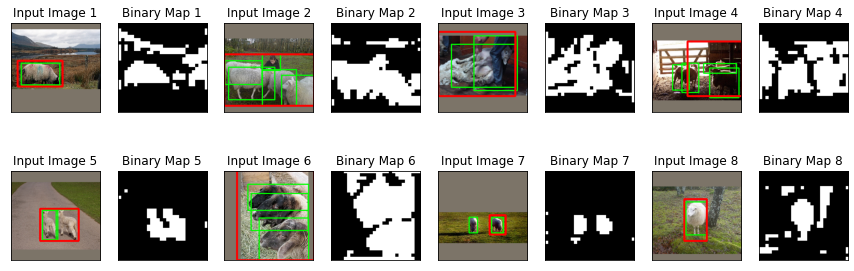

In [ ]:
print("DDT block5_conv3")
display(binary_map1, binary_box1)

DDT block4_conv3
Green: Ground Truth 
Red: prediction


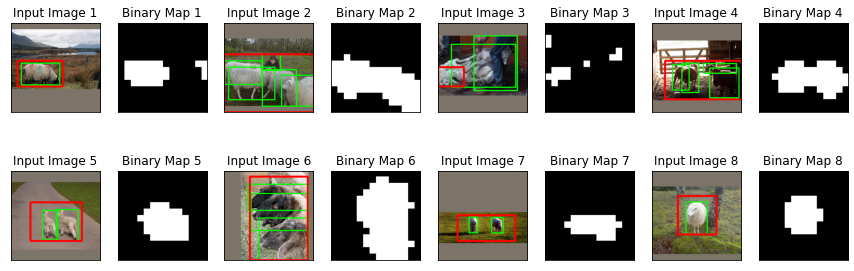

In [ ]:
print("DDT block4_conv3")
display(binary_map2, binary_box2)

DDT plus output
Green: Ground Truth 
Red: prediction


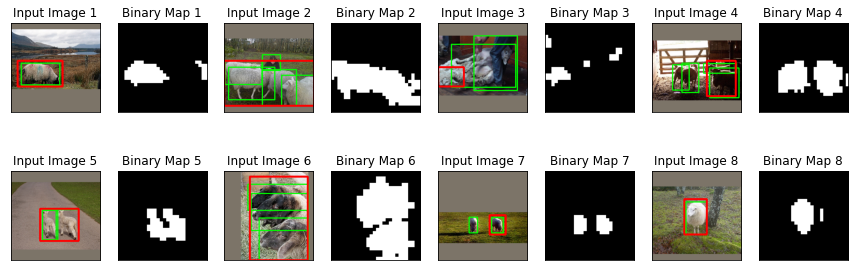

In [ ]:
print("DDT plus output")
display(dtt_plus_binary_map, ddt_plus_binary_box)

# **Reflection**
## DDT
Initially the first DDT took the block5_con3 output from the VGG base model. For the dog dataset with 1 object per image it performed well. When multiple objects from the sheep dataset was introduced this led to problems. Shown above when 2 sheep are seperated only one is detected. For the block4 DDT this isn't an issue, as it detects multiple sheep. This shows that the block5 has more semantic information and block4 is more generalized. This means is due to block5 being deeper layer in the model while block4 is shallower. The combination of the 2 is shown in the DDT plus.

## DDT plus
The DDT plus possess a mixture of the best and worst outputs of the previous DDTs, we can see yhis in image 1 where the bounding box where the more restricted bounding box is selected from block4 rather than block5 which doesn't capture where the sheep is located within the image. On the other hand with image 3 instead of selecting block5 image where both sheep are captured the more generic block4 outcome is chosen. This loses all relevant information as the block4 image 3 doesn't capture the sheep correctly. For images 4 and 7 we can see that not all sheep have a bounding box around them. The DDT plus has chosen the more semantic DDT (block5) over the more general. However, when examining the binary maps we can see that the strength of the DDT plus. the noise of block5 has been reduced and the simpicity of block4 has refined it to only the areas with the sheep quiete well.

## Summary
With some improvement on the binary box method, possilby by recording other significant images of the sheep, the DDT+ could significantly outperform both DDTs. However, this would be quiete complicated to get perfect, for example binary map image 8 for the DDT plus regards a tree as a sheep, While in binary map image 7 both sheep are captured. This calls into question whether a higher recall or precision is required of the detector. From there the model can be optimized to better suit this requirement.


